Episode 1: reward: -978.365911771696
Episode 2: reward: -896.5189154994013
Episode 3: reward: -1679.8065966475742
Episode 4: reward: -1369.7380998965073
Episode 5: reward: -1823.0225049999362
Episode 6: reward: -1921.1655853752172
Episode 7: reward: -627.0296818637613
Episode 8: reward: -742.6812254134895
Episode 9: reward: -1310.7832371165841
Episode 10: reward: -1197.7584176426383
Episode 11: reward: -1288.4675615186127
Episode 12: reward: -1233.690188882555
Episode 13: reward: -1143.0888338826321
Episode 14: reward: -1712.1944790152713
Episode 15: reward: -1175.1508445256022
Episode 16: reward: -1791.1221690198865
Episode 17: reward: -1072.4458225093629
Episode 18: reward: -1674.216209948598
Episode 19: reward: -1477.6871851170545
Episode 20: reward: -1293.8746617485883
Episode 21: reward: -1043.805642202659
Episode 22: reward: -1168.1836716135165
Episode 23: reward: -1521.8976156907859
Episode 24: reward: -857.8846092362644
Episode 25: reward: -627.5591833135843
Episode 26: reward:

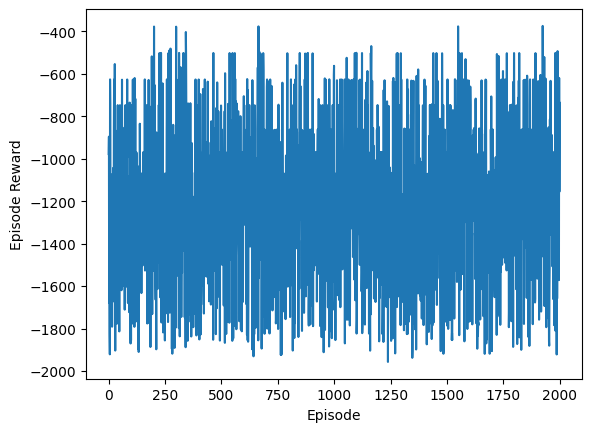

In [2]:
import tensorflow as tf
import numpy as np
from tensorflow.keras.layers import Dense
from tensorflow.keras import Model
import matplotlib.pyplot as plt

class ActorCritic(Model):
    def __init__(self, num_actions):
        super(ActorCritic, self).__init__()
        self.actor_dense1 = Dense(128, activation='relu')
        self.actor_dense2 = Dense(128, activation='relu')
        self.actor_logits = Dense(num_actions)
        self.critic_dense1 = Dense(128, activation='relu')
        self.critic_dense2 = Dense(128, activation='relu')
        self.critic_values = Dense(1)

    def call(self, inputs):
        x = tf.convert_to_tensor(inputs)
        hidden_actor = self.actor_dense1(x)
        hidden_actor = self.actor_dense2(hidden_actor)
        hidden_critic = self.critic_dense1(x)
        hidden_critic = self.critic_dense2(hidden_critic)
        return self.actor_logits(hidden_actor), self.critic_values(hidden_critic)

def compute_loss(logits, values, actions, rewards):
    neg_logprob = tf.nn.sparse_softmax_cross_entropy_with_logits(logits=logits, labels=actions)
    returns = compute_returns(rewards)
    advantage = returns - values
    value_loss = advantage ** 2
    policy_loss = neg_logprob * tf.stop_gradient(advantage)
    return tf.reduce_mean(policy_loss + value_loss)

def compute_returns(rewards):
    returns = np.zeros_like(rewards)
    running_sum = 0
    for t in reversed(range(0, len(rewards))):
        running_sum = running_sum * 0.99 + rewards[t]
        returns[t] = running_sum
    return returns

def train_step(model, optimizer, observations, actions, rewards):
    with tf.GradientTape() as tape:
        logits, values = model(observations)
        loss = compute_loss(logits, values, actions, rewards)
    grads = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(grads, model.trainable_variables))

if __name__ == '__main__':
    import gym

    env = gym.make('Pendulum-v1')
    model = ActorCritic(num_actions=env.action_space.shape[0])
    optimizer = tf.keras.optimizers.Adam(learning_rate=0.01)

    obs = env.reset()
    episode_reward = 0
    episode_rewards = []
    episode_num = 1
    while True:
        logits, _ = model(obs.reshape((1,-1)))
        action_probs = tf.nn.softmax(logits)
        action_index = np.random.choice(env.action_space.shape[0], p=action_probs[0].numpy())
        action = np.array([action_index])
        next_observation, reward, done, _ = env.step(action)
        episode_reward += reward

        train_step(model,
                   optimizer,
                   obs.reshape((1,-1)),
                   np.array([action_index]),
                   np.array([reward]))

        if done:
            print(f"Episode {episode_num}: reward: {episode_reward}")
            episode_rewards.append(episode_reward)
            episode_reward = 0
            obs = env.reset()
            episode_num += 1
        else:
            obs = next_observation

        if len(episode_rewards) >= 2000:
            plt.plot(episode_rewards)
            plt.xlabel('Episode')
            plt.ylabel('Episode Reward')
            plt.show()
            break